In [1]:
import cv2
import numpy as np
import random
import math
from matplotlib import pyplot as plt
from collections import deque


# General settings
seed = 42
# image_file = "sample_map.png"

# Task 1 - Occupancy map
unsafe_kernel_size = 5
unsafe_iterations = 5

In [2]:

class Node:
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y
    
    def get_point(self):
        return (self.x,self.y)
    
    def get_ID(self):
        return self.id

class Graph:
    def __init__(self):
        self.nodes = {}
        self.edges = {}

    def add_node(self, node_id, x, y):
        if node_id not in self.nodes:
            self.nodes[node_id] = Node(node_id,x,y)
            self.edges[node_id] = {}

    def add_edge(self, node_id1, node_id2, weight):
        if node_id1 in self.nodes and node_id2 in self.nodes:
            if node_id1 not in self.edges:
                self.edges[node_id1] = {}
            self.edges[node_id1][node_id2] = weight
            # add edge going the opposite direction as well
            if node_id2 not in self.edges:
                self.edges[node_id2] = {}
            self.edges[node_id2][node_id1] = weight

    def remove_edge(self, node_id1, node_id2):
        if node_id1 in self.nodes and node_id2 in self.nodes:
            if node_id2 in self.edges[node_id1]:
                del self.edges[node_id1][node_id2]
            if node_id1 in self.edges[node_id2]:
                del self.edges[node_id2][node_id1]
    
    def get_nodes(self):
        return list(self.nodes.keys())
    
    def get_neighbours(self, node_id):
        if node_id in self.edges:
            return list(self.edges[node_id].keys())
        else:
            return []






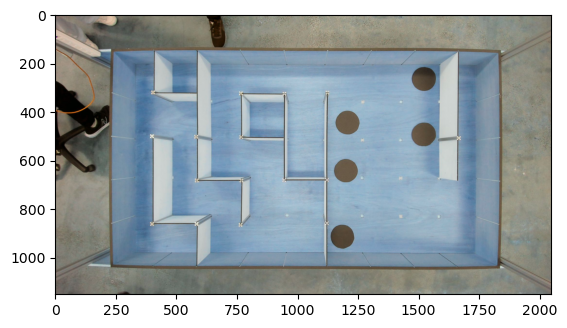

[[ 1.00000000e+00 -1.05471187e-15 -2.30000000e+02]
 [-6.24500451e-16  9.71910112e-01 -1.45786517e+02]
 [-1.13841228e-18 -1.45012041e-18  1.00000000e+00]]


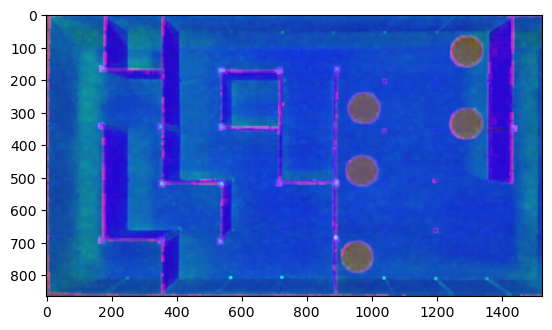

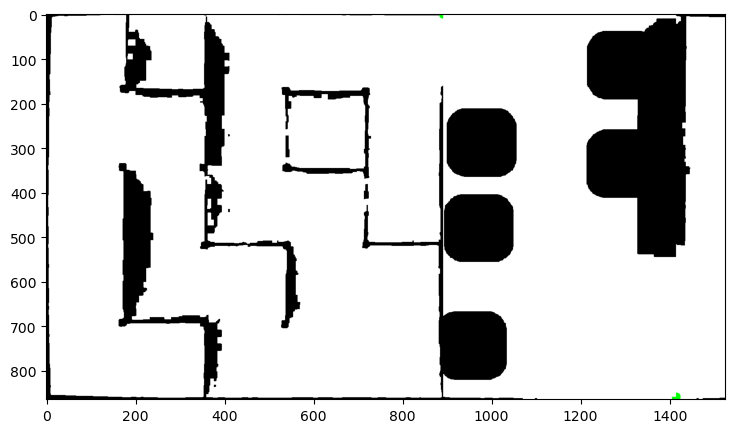

In [3]:
img = cv2.imread('maze_r3.jpg') # TODO: Replace with code to load the image
imgHSV = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
plt.imshow(img)
plt.show()
# pts1 = np.float32([[215,125],[1740,125],[215,990],[1740,990]]) # four points on the first image
pts1 = np.float32([[230,150],[1800,150],[230,1040],[1800,1040]]) # four points on the first image

# pts2 = np.float32([[0,0],[1525,0],[0,865],[1525,865]]) # four points on the second image
pts2 = np.float32([[0,0],[1570,0],[0,865],[1570,865]]) # four points on the second image

H = cv2.getPerspectiveTransform(pts1,pts2) # homography matrix
print(H)
cropped_image = cv2.warpPerspective(imgHSV, H, (1525,865))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

cropped_image = cv2.dilate(cropped_image,kernel,iterations=4)

plt.imshow(cropped_image)
plt.show()




# imgHSVMasked = cv2.inRange(cropped_image,(6,45,98),(87,255,237))
imgHSVMasked = cv2.inRange(cropped_image,(33,0,0),(178,255,255))

imgHSVFinal = imgHSVMasked.copy()
imgHSVFinal = cv2.cvtColor(imgHSVFinal, cv2.COLOR_GRAY2RGB)  # Convert single channel to BGR
imgHSVFinal = cv2.erode(imgHSVFinal, kernel, iterations=3)
inverted_image = cv2.bitwise_not(imgHSVFinal)
# inverted_image = cv2.dilate(inverted_image, kernel, iterations=2)

x_start = 5
x_end = 3

x_obstacle = int((1570/9)*x_start)+20
inverted_image = cv2.circle(inverted_image,(x_obstacle,0),10,(0,255,0),-1)

y_obstacle = 0
w_obstacle = int((1570/9)*x_end)
h_obstacle =860
final_width = 1570-x_obstacle-w_obstacle
inverted_image = cv2.circle(inverted_image,(w_obstacle+x_obstacle,h_obstacle),10,(0,255,0),-1)

# x, y, w, h = 860, 0, 500, 860  # Example values
cropped_image = inverted_image[y_obstacle:y_obstacle+h_obstacle, x_obstacle:x_obstacle+w_obstacle]
kernel_size = 5
kernel = np.ones((kernel_size, kernel_size), np.uint8)
dilation = 5
iterations = 20

cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY)

extra_eroded_image = cv2.dilate(cropped_image, kernel, iterations=dilation)

extra_eroded_image = cv2.erode(extra_eroded_image, kernel, iterations=iterations)

extra_eroded_image = cv2.cvtColor(extra_eroded_image, cv2.COLOR_GRAY2RGB)


inverted_image[y_obstacle:y_obstacle+h_obstacle, x_obstacle:x_obstacle+w_obstacle] = extra_eroded_image



plt.figure(figsize = (9,5))
plt.imshow(inverted_image)

plt.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]


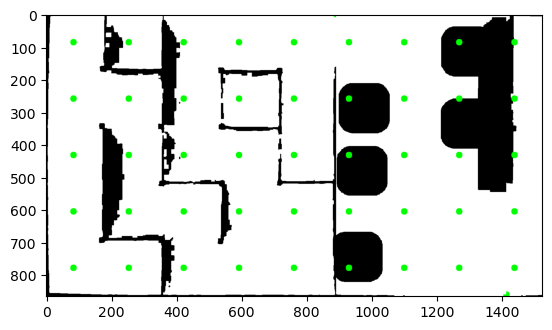

In [4]:
bfs_image = inverted_image.copy()
bfs_graph = Graph()

height,width,_ = bfs_image.shape
x_step = width/(9)
y_step = height/(5)

# bfs_image = cv2.circle(bfs_image,(300,200),10,(0,255,0),-1)
# bfs_image = cv2.circle(bfs_image,(550,200),10,(0,255,0),-1)

node_id = 0
for row in range(5):
    for col in range(9):
        x = ((col+0.5)*x_step)
        y = ((row+0.5)*y_step)
        bfs_graph.add_node((node_id),x,y)
        bfs_image = cv2.circle(bfs_image,(int(x),int(y)),10,(0,255,0),-1)
        node_id += 1

nodes_list_first = bfs_graph.get_nodes()
print(nodes_list_first)
plt.imshow(bfs_image,cmap='gray')
plt.show()

[45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144]


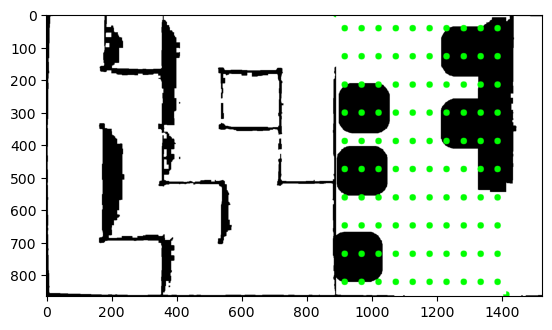

In [5]:
bfs_image2 = inverted_image.copy()
bfs_graph2 = Graph()

height,width,_ = bfs_image2.shape
x_step_Middle = (w_obstacle)/(10)
y_step_Middle = height/(10)

# bfs_image = cv2.circle(bfs_image,(300,200),10,(0,255,0),-1)
# bfs_image = cv2.circle(bfs_image,(550,200),10,(0,255,0),-1)

node_id_Middle = node_id
for row in range(10):
    for col in range(10):
        x = ((col+0.5)*x_step_Middle + x_obstacle)
        y = ((row+0.5)*y_step_Middle)
        bfs_graph2.add_node((node_id_Middle),x,y)
        bfs_image2 = cv2.circle(bfs_image2,(int(x),int(y)),10,(0,255,0),-1)
        node_id_Middle += 1

nodes_list_middle = bfs_graph2.get_nodes()
print(nodes_list_middle)
plt.imshow(bfs_image2,cmap='gray')
plt.show()


[145, 146, 147, 148, 149]


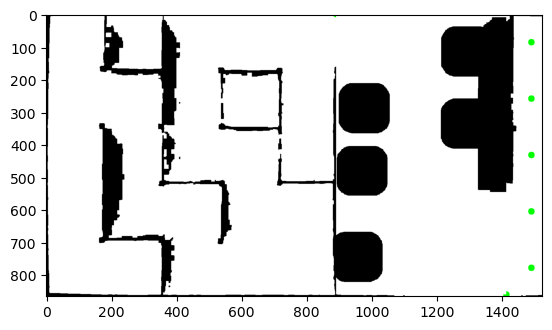

In [6]:
bfs_image3 = inverted_image.copy()
bfs_graph3 = Graph()

height,width,_ = bfs_image3.shape
x_step_Final = final_width/(1)
# x_step_Final = 150/(1)

y_step_Final = height/(5)

# bfs_image = cv2.circle(bfs_image,(300,200),10,(0,255,0),-1)
# bfs_image = cv2.circle(bfs_image,(550,200),10,(0,255,0),-1)

node_id_Final = node_id_Middle 
for row in range(5):
    for col in range(1):
        x = ((col+0.5)*x_step_Final + (x_obstacle+w_obstacle))
        y = ((row+0.5)*y_step_Final)
        bfs_graph3.add_node((node_id_Final),x,y)
        bfs_image3 = cv2.circle(bfs_image3,(int(x),int(y)),10,(0,255,0),-1)
        node_id_Final += 1

nodes_list_last = bfs_graph3.get_nodes()
print(nodes_list_last)
plt.imshow(bfs_image3,cmap='gray')
plt.show()



In [7]:
def path_clear(image, x1, y1, x2, y2):
    clear = True
    x1 = int(x1)
    y1 = int(y1)
    x2 = int(x2)
    y2 = int(y2)
    x = abs(x2-x1)
    y = abs(y2-y1)

    # if the nodes are vertical (same x axis, different y values)
    # should be equal to 0, but in case there are rounding discrepancies in coordinate values
    if x == 0:
        for i in range(y):
            # if there is an red or black obstacle, return false
            if( image[y2+i,x1] == [0,0,0]).all():
                clear = False
    
    # if the nodes are horizontal (same y axis, different x values)
    else:
        for i in range(x):

            if (image[y1][x2+i] == [0,0,0]).all():
                clear = False    
    return clear

def is_close(x1, x2, tol=1.0):
    return abs(x1 - x2) <= tol

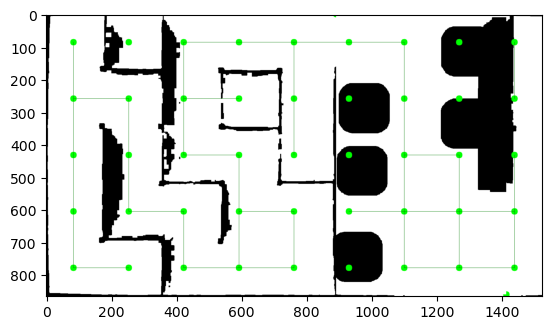

In [8]:
i = 0
for col in range(9):
    for row in range(5):
        node_id1 = col*5 + row

        x1,y1 = bfs_graph.nodes[node_id1].get_point()
        x_left = x1-x_step
        y_left = y1
        x_up = x1
        y_up = y1-y_step

        # Check for available node to the left of current node
        if path_clear(bfs_image, x1,y1,x_left,y_left):
            # draw line between connecting nodes
            cv2.line(bfs_image, (int(x1),int(y1)), (int(x_left),int(y_left)), (0,125,0),1)
            node_id2 = 0
            for n in range(node_id-1):
                # Check if the current point matches a point of a node, if so, that is node 2 
                # (used to find index of node 2 to then create an edge)
                if (is_close(bfs_graph.nodes[n].get_point()[0], x_left)) and (is_close(bfs_graph.nodes[n].get_point()[1], y_left)):
                    node_id2 = n
                    bfs_graph.add_edge(node_id1, node_id2, 1)

        # Check for available node above current node
        if path_clear(bfs_image, x1,y1,x_up,y_up):
            cv2.line(bfs_image, (int(x1),int(y1)), (int(x_up),int(y_up)), (0,125,0),1)
            node_id2 = 0
            # Check if the current point matches a point of a node, if so, that is node 2
            for m in range(node_id-1):
                if (is_close(bfs_graph.nodes[m].get_point()[0], x_up)) and (is_close(bfs_graph.nodes[m].get_point()[1], y_up)):
                        node_id2 = m
                        bfs_graph.add_edge(node_id1, node_id2, 1)
                           
plt.imshow(bfs_image)
plt.show()

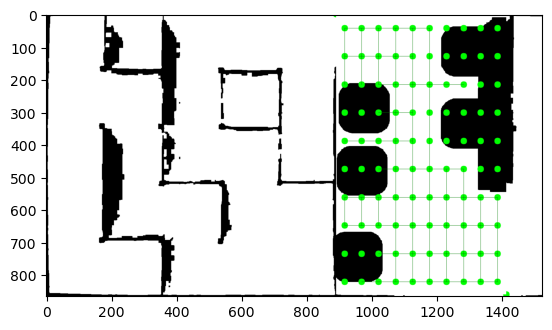

In [9]:
for node_id1 in bfs_graph2.get_nodes():
    x1, y1 = bfs_graph2.nodes[node_id1].get_point()
    x_right = x1 + x_step_Middle
    y_right = y1
    x_up = x1
    y_up = y1 - y_step_Middle

    # Check for available node to the right of the current node
    if x_right <= 1400 and path_clear(bfs_image2, x1, y1, x_right, y_right):
        cv2.line(bfs_image2, (int(x1), int(y1)), (int(x_right), int(y_right)), (0, 125, 0), 1)
        for node_id2 in bfs_graph2.get_nodes():
            if (is_close(bfs_graph2.nodes[node_id2].get_point()[0], x_right)) and \
               (is_close(bfs_graph2.nodes[node_id2].get_point()[1], y_right)):
                bfs_graph2.add_edge(node_id1, node_id2, 1)
                break

    # Check for available node above the current node
    if y_up >= 0 and path_clear(bfs_image2, x1, y1, x_up, y_up):
        cv2.line(bfs_image2, (int(x1), int(y1)), (int(x_up), int(y_up)), (0, 125, 0), 1)
        for node_id2 in bfs_graph2.get_nodes():
            if (is_close(bfs_graph2.nodes[node_id2].get_point()[0], x_up)) and \
               (is_close(bfs_graph2.nodes[node_id2].get_point()[1], y_up)):
                bfs_graph2.add_edge(node_id1, node_id2, 1)
                break

plt.imshow(bfs_image2)
plt.show()



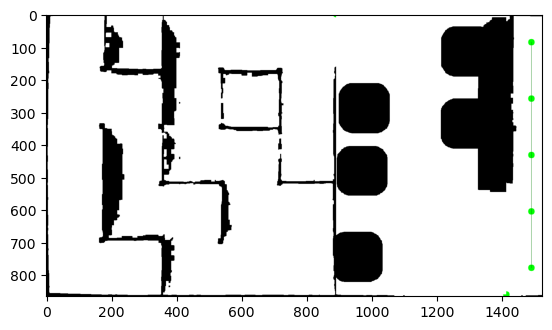

In [10]:
for node_id1 in bfs_graph3.get_nodes():
    x1, y1 = bfs_graph3.nodes[node_id1].get_point()
    x_right = x1 + x_step_Final
    y_right = y1
    x_up = x1
    y_up = y1 - y_step_Final

    # Check for available node to the right of the current node
    if x_right <= 1500 and path_clear(bfs_image3, x1, y1, x_right, y_right):
        cv2.line(bfs_image3, (int(x1), int(y1)), (int(x_right), int(y_right)), (0, 125, 0), 1)
        for node_id2 in bfs_graph3.get_nodes():
            if (is_close(bfs_graph3.nodes[node_id2].get_point()[0], x_right)) and \
               (is_close(bfs_graph3.nodes[node_id2].get_point()[1], y_right)):
                bfs_graph3.add_edge(node_id1, node_id2, 1)
                break

    # Check for available node above the current node
    if y_up >= 0 and path_clear(bfs_image3, x1, y1, x_up, y_up):
        cv2.line(bfs_image3, (int(x1), int(y1)), (int(x_up), int(y_up)), (0, 125, 0), 1)
        for node_id2 in bfs_graph3.get_nodes():
            if (is_close(bfs_graph3.nodes[node_id2].get_point()[0], x_up)) and \
               (is_close(bfs_graph3.nodes[node_id2].get_point()[1], y_up)):
                bfs_graph3.add_edge(node_id1, node_id2, 1)
                break

plt.imshow(bfs_image3)
plt.show()

Path: [0, 9, 10, 19, 28, 29, 38, 39, 30, 21, 20, 11, 2, 3, 4, 5, 6, 15, 24, 33, 42, 43, 44]


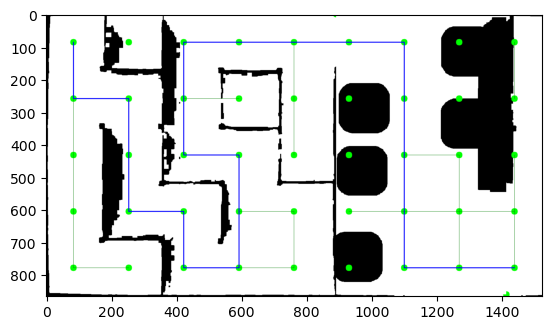

In [11]:
def bfs(graph, start_node_id, end_node_id):
    queue = deque([start_node_id])
    visited = set()
    parents = {start_node_id: None}
    
    while queue:
        current_node_id = queue.popleft()
        
        # Skip this node if we have already visited it
        if current_node_id in visited:
            continue
        
        # Mark this node as visited
        visited.add(current_node_id)
        
        # Check if we have reached the end node
        if current_node_id == end_node_id:
            path = []
            while current_node_id is not None:
                path.append(current_node_id)
                current_node_id = parents[current_node_id]
            path.reverse()
            return path
        
        # Get neighbours of the current node
        neighbours = graph.get_neighbours(current_node_id)
        
        # Reverse the order of the neighbours to match the spec
        neighbours.reverse()
        
        # Add neighbours to the queue and set their parent
        for neighbour_id in neighbours:
            if neighbour_id not in visited and neighbour_id not in queue:
                queue.append(neighbour_id)
                parents[neighbour_id] = current_node_id
    
    # If no path is found, return an empty list
    return []

# Task 3.2: Impliment BFS continued
start = (0,0)
end = (8,4)
##### TO DO:::::::: GET A WAY TO ADD THE START AND END NODES TO THE GRID FOR BFS


# Run bfs and display the output
path = bfs(bfs_graph,0,44)

length = len(path)
for i in range(length-1):
    x1,y1 = bfs_graph.nodes[path[i]].get_point()
    x2,y2 = bfs_graph.nodes[path[i+1]].get_point()
    
    cv2.line(bfs_image, (int(x1),int(y1)), (int(x2),int(y2)), (0,0,255),2)



# Display resulting image
print(f"Path: {path}")
plt.imshow(bfs_image)
plt.show()



Path: [46, 56, 57, 67, 68, 78, 88, 98, 108, 118, 128, 138, 139, 140, 141, 142, 143, 144]


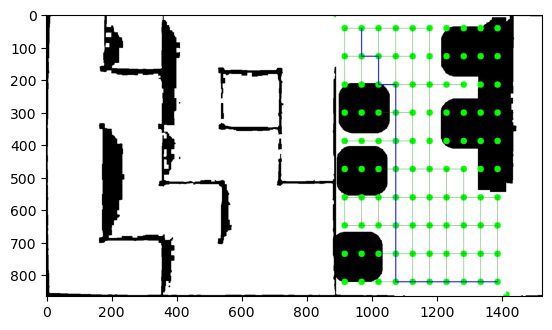

In [12]:
node1 = nodes_list_middle[1]
nodes_list_length = len(nodes_list_middle)
node2 = nodes_list_middle[nodes_list_length-1]
pathMiddle = bfs(bfs_graph2,node1,node2)

length = len(pathMiddle)
for i in range(length-1):
    x1,y1 = bfs_graph2.nodes[pathMiddle[i]].get_point()
    x2,y2 = bfs_graph2.nodes[pathMiddle[i+1]].get_point()

    cv2.line(bfs_image2, (int(x1),int(y1)), (int(x2),int(y2)), (0,0,255),2)



# Display resulting image
print(f"Path: {pathMiddle}")
plt.imshow(bfs_image2)
plt.show()


Path: [146, 147, 148, 149]


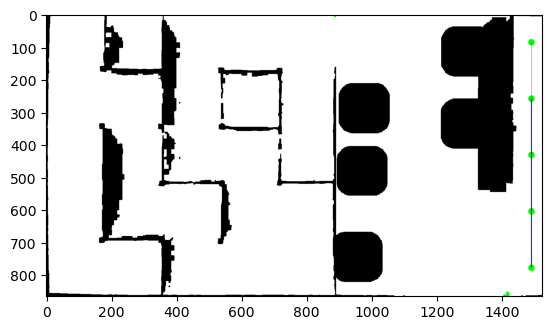

In [13]:
node1 = nodes_list_last[1]
nodes_list_length = len(nodes_list_last)
node2 = nodes_list_last[nodes_list_length-1]

pathFinal = bfs(bfs_graph3,node1,node2)

length = len(pathFinal)
for i in range(length-1):
    x1,y1 = bfs_graph3.nodes[pathFinal[i]].get_point()
    x2,y2 = bfs_graph3.nodes[pathFinal[i+1]].get_point()

    cv2.line(bfs_image3, (int(x1),int(y1)), (int(x2),int(y2)), (0,0,255),2)



# Display resulting image
print(f"Path: {pathFinal}")
plt.imshow(bfs_image3)
plt.show()

In [14]:
def find_direction(graph, path):
    # north is index 0, east 1, south 2, west 3
    # right 0, left 1, up 2, down 3

    lookup = [
    ["rf", "lf", "f", " error "], #north
    ["f", " error ", "lf", "rf"], #east
    ["lf", "rf", " error ", "f"], #south
    [" error ", "f", "rf", "lf"]  #west
    ]

    commands = "f"
    heading = 0
    
    if graph.nodes[path[1]].x > graph.nodes[path[0]].x:
        heading = 1 #east
    elif graph.nodes[path[1]].x < graph.nodes[path[0]].x:
        heading = 3 #west
    elif graph.nodes[path[1]].y < graph.nodes[path[0]].y:
        heading = 0 #north
    elif graph.nodes[path[1]].y > graph.nodes[path[0]].y:
        heading = 2 #south

        #print("starting heading", heading)

    for i in range(1, len(path) - 1):
        #print(heading)
        if graph.nodes[path[i+1]].x > graph.nodes[path[i]].x: #right
            commands += lookup[heading][0]
            heading = 1
            #print("east")
        elif graph.nodes[path[i+1]].x < graph.nodes[path[i]].x: # left
            commands += lookup[heading][3]
            heading = 3
            #print("west")
        elif graph.nodes[path[i+1]].y < graph.nodes[path[i]].y: #up
            commands += lookup[heading][2]
            heading = 0
            #print("north")
        elif graph.nodes[path[i+1]].y > graph.nodes[path[i]].y: #down
            commands += lookup[heading][3]
            heading = 2
            #print("south")
    return commands

print(find_direction(bfs_graph, path))
print(find_direction(bfs_graph2, pathMiddle))
print(find_direction(bfs_graph3, pathFinal))



# def find_direction(graph, path):
#     # north is index 0, east 1, south 2, west 3
#     # right 0, left 1, up 2, down 3

#     lookup_normal = [
#     ["rf", "lf", "f", " error "], #north
#     ["f", " error ", "lf", "rf"], #east
#     ["lf", "rf", " error ", "f"], #south
#     [" error ", "f", "rf", "lf"]  #west
#     ]

#     lookup_short = [
#     ["rh", "lh", "h", " error "], #north
#     ["h", " error ", "lh", "rh"], #east
#     ["lh", "rh", " error ", "h"], #south
#     [" error ", "h", "rh", "lh"]  #west
#     ]

#     commands = "f"
#     heading = 0
    
#     if graph.nodes[path[1]].x > graph.nodes[path[0]].x:
#         heading = 1 #east
#     elif graph.nodes[path[1]].x < graph.nodes[path[0]].x:
#         heading = 3 #west
#     elif graph.nodes[path[1]].y < graph.nodes[path[0]].y:
#         heading = 0 #north
#     elif graph.nodes[path[1]].y > graph.nodes[path[0]].y:
#         heading = 2 #south

#         #print("starting heading", heading)

#     for i in range(1, len(path) - 1):
#         #print(heading)
#         if graph.nodes[path[i+1]].x > graph.nodes[path[i]].x: #east
#             if graph.edges[path[i]][path[i+1]] > 160:
#                 commands += lookup_normal[heading][0]
#             else:
#                 commands += lookup_short[heading][0]
#             heading = 1
#             #print("east")
#         elif graph.nodes[path[i+1]].x < graph.nodes[path[i]].x: #west
#             if graph.edges[path[i]][path[i+1]] > 160:
#                 commands += lookup_normal[heading][1]
#             else:
#                 commands += lookup_short[heading][1]
#             heading = 3
#             #print("west")
#         elif graph.nodes[path[i+1]].y < graph.nodes[path[i]].y: #north
#             if graph.edges[path[i]][path[i+1]] > 160:
#                 commands += lookup_normal[heading][2]
#             else:
#                 commands += lookup_short[heading][2]
#             heading = 0
#             #print("north")
#         elif graph.nodes[path[i+1]].y > graph.nodes[path[i]].y: #south
#             if graph.edges[path[i]][path[i+1]] > 160:
#                 commands += lookup_normal[heading][3]
#             else:
#                 commands += lookup_short[heading][3]
#             heading = 2
#             #print("south")
#     return commands
# print(find_direction(bfs_graph,path))

flfrfflfrflflff error rffrffffrfffflff
flfrflfrffffffflffffff
fff
